In [1]:
#Imports
# -*- coding: utf-8 -*-

import pandas as pd
import csv
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
#Cargamos dataset
dataML_section = pd.read_csv('../TFM/csv_bigdata/datos_filtrados.csv',sep=';',engine='python')

In [3]:
dataML_section.dtypes

fecha          object
dia_semana     object
hora           object
id_tramo       object
des_tramo      object
estado          int64
longitud      float64
latitud       float64
dtype: object

In [4]:
#Convertimos la columna estado a integuer
dataML_section["estado"] = dataML_section["estado"].astype(int)

#Unimos columna fecha con columna hora, para crear columna tiempo
dataML_section['tiempo'] = pd.to_datetime(dataML_section['fecha'] + ' ' + dataML_section['hora'])
#dataML_section['tiempo'] = pd.to_datetime(dataML_section['fecha'])

#Cambiamos la columna tiempo a datetime
dataML_section["tiempo"] = dataML_section["tiempo"].astype('datetime64[ns]') 

#Convertimos la columna tiempo a timestamp
dataML_section['timestamp'] = dataML_section['tiempo'].values.astype(np.int64) // 10 ** 9  #Convert to timestamp

#Convertimos la columna dia_semana a categórica
conditions_days = [(dataML_section['dia_semana'] == 'Lunes'),
                  (dataML_section['dia_semana'] == 'Martes'),
                  (dataML_section['dia_semana'] == 'Miércoles'),
                  (dataML_section['dia_semana'] == 'Jueves'),
                  (dataML_section['dia_semana'] == 'Viernes'),
                  (dataML_section['dia_semana'] == 'Sábado'),
                  (dataML_section['dia_semana'] == 'Domingo')]

values_days = [1,2,3,4,5,6,7]

dataML_section['dias'] = np.select(conditions_days,values_days)
dataML_section['dias'].values.astype(np.int64)

#Create new column id from id_tramo replacing column A -> 10 and B -> 20 to int
dataML_section['id'] = dataML_section['id_tramo'].str.replace(r'^A', '10').str.replace(r'^B', '20').astype(int)

dataML_section.head(5)

,fecha,dia_semana,hora,id_tramo,des_tramo,estado,longitud,latitud,tiempo,timestamp,dias,id
0,2015-01-01,Jueves,00:15:01,A102,ERNESTO FERRER,37,-0.354378,39.471478,2015-01-01 00:15:01,1420071301,4,10102
1,2015-01-01,Jueves,00:15:01,A104,EUGENIA VIÑES,33,-0.325181,39.467414,2015-01-01 00:15:01,1420071301,4,10104
2,2015-01-01,Jueves,00:15:01,A124,GUILLEM DE CASTRO,139,-0.383419,39.470396,2015-01-01 00:15:01,1420071301,4,10124
3,2015-01-01,Jueves,00:15:01,A127,GUILLEM DE CASTRO,187,-0.384150,39.475677,2015-01-01 00:15:01,1420071301,4,10127
4,2015-01-01,Jueves,00:15:01,A122,GRAN VIA RAMON Y CAJAL,218,-0.335824,39.460994,2015-01-01 00:15:01,1420071301,4,10122


**Categorizamos el tráfico:**

- 1 -> FLUIDO
- 2 -> DENSO
- 3 -> CONGESTIONADO
- 4 -> ATASCADO

In [5]:
#Creación Variable desc_estado string
dataML_section['desc_estado'] = \
np.where(
    (dataML_section['estado'] > 0) & (dataML_section['estado']<= 500), 'FLUIDO',\
    np.where(
        (dataML_section['estado'] > 500) & (dataML_section['estado']<= 1500), 'DENSO',\
            np.where(
                (dataML_section['estado'] > 1500) & (dataML_section['estado']<= 3000), 'CONGESTIONADO','ATASCADO'\
                    )
        )
)

                               
#Creación Variable tipo_estado integer
dataML_section['tipo_estado'] = \
np.where(
    (dataML_section['desc_estado'] == 'FLUIDO'), 1,\
    np.where(
        (dataML_section['desc_estado'] == 'DENSO'), 2,\
        np.where(
            (dataML_section['desc_estado'] == 'CONGESTIONADO'), 3,4\
        )
    )
)

dataML_section.head(5)

,fecha,dia_semana,hora,id_tramo,des_tramo,estado,longitud,latitud,tiempo,timestamp,dias,id,desc_estado,tipo_estado
0,2015-01-01,Jueves,00:15:01,A102,ERNESTO FERRER,37,-0.354378,39.471478,2015-01-01 00:15:01,1420071301,4,10102,FLUIDO,1
1,2015-01-01,Jueves,00:15:01,A104,EUGENIA VIÑES,33,-0.325181,39.467414,2015-01-01 00:15:01,1420071301,4,10104,FLUIDO,1
2,2015-01-01,Jueves,00:15:01,A124,GUILLEM DE CASTRO,139,-0.383419,39.470396,2015-01-01 00:15:01,1420071301,4,10124,FLUIDO,1
3,2015-01-01,Jueves,00:15:01,A127,GUILLEM DE CASTRO,187,-0.384150,39.475677,2015-01-01 00:15:01,1420071301,4,10127,FLUIDO,1
4,2015-01-01,Jueves,00:15:01,A122,GRAN VIA RAMON Y CAJAL,218,-0.335824,39.460994,2015-01-01 00:15:01,1420071301,4,10122,FLUIDO,1


**Frecuencias Estado Tráfico**

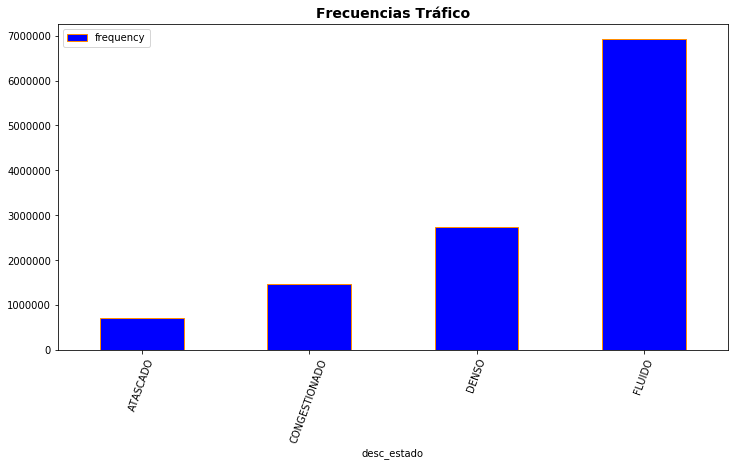

In [6]:
freq_time = dataML_section.groupby("desc_estado").agg(frequency=("desc_estado", "count"))
freq_time.plot(kind='bar',color='blue',edgecolor='darkorange',figsize=(12,6))
plt.title('Frecuencias Tráfico',fontweight='bold',fontsize=14)
plt.xticks(rotation=70)
plt.show()

In [7]:
#Comprobamos Dimensión
dataML_section.shape

(11817827, 14)

In [8]:
#Comprobamos Filas Totales
counter = dataML_section.shape[0]
print('Filas: ',counter)

Filas:  11817827


In [9]:
#Descripción Variables
dataML_section['estado'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
estado,11817827.0,809.592015,1093.228395,1.0,98.0,346.0,1059.0,17982.0


In [10]:
dataML_section[['timestamp','dias','id','estado','tipo_estado']].dtypes

timestamp      int64
dias           int64
id             int64
estado         int64
tipo_estado    int64
dtype: object

In [11]:
#dataML_section_LR = dataML_section.groupby(['timestamp','id'],as_index = False).estado.mean() #58%
#dataML_section_LR = dataML_section.groupby(['timestamp','dias'],as_index = False).estado.mean() #59%
#dataML_section_LR = dataML_section.groupby(['timestamp'],as_index = False).estado.mean() #59%
dataML_section_LR = dataML_section.groupby(['timestamp','dias','id','tipo_estado'],as_index = False).estado.mean() #59%
dataML_section_LR.head(5)

,timestamp,dias,id,tipo_estado,estado
0,1420071301,4,101,1,140
1,1420071301,4,103,1,35
2,1420071301,4,105,1,173
3,1420071301,4,107,1,120
4,1420071301,4,108,1,143


In [12]:
#Comprobamos Filas Totales
#Con horas = 11729306
#Sin horas = 142182

counter_2 = dataML_section_LR.shape[0]
print('Filas: ',counter_2)

Filas:  11729306


In [13]:
counter_2 = dataML_section_LR.shape[0]
print('Filas: ',counter_2)

Filas:  11729306


In [49]:
#Guardamos los datos filtrados anteriormente en un csv
ml_data = 'datos_DL.csv'
try:
    dataML_section_LR.to_csv(ml_data,sep=';', index=False, header = True)
    print('Archivo Creado Correctamente')
except EmptyDataError as ex:
    print('Datos Vacíos: \n',ex)
except ParserError as ex:
    print('Error Parseo Archivo: \n',ex)
except Exception as ex:
    print('Archivo Creado con Errores: \n',ex)

Archivo Creado Correctamente


**Dataset Predicciones**

In [24]:
#Filtramos los datos de la primera semana de Enero de 2015
df_pred = dataML_section[(dataML_section['fecha'] >= '2015-01-01')& \
                              (dataML_section['fecha'] <= '2015-01-07')].reset_index()

df_pred.head(5)

,index,fecha,dia_semana,hora,id_tramo,des_tramo,estado,longitud,latitud,tiempo,timestamp,dias,id,desc_estado,tipo_estado
0,0,2015-01-01,Jueves,00:15:01,A102,ERNESTO FERRER,37,-0.354378,39.471478,2015-01-01 00:15:01,1420071301,4,10102,FLUIDO,1
1,1,2015-01-01,Jueves,00:15:01,A104,EUGENIA VIÑES,33,-0.325181,39.467414,2015-01-01 00:15:01,1420071301,4,10104,FLUIDO,1
2,2,2015-01-01,Jueves,00:15:01,A124,GUILLEM DE CASTRO,139,-0.383419,39.470396,2015-01-01 00:15:01,1420071301,4,10124,FLUIDO,1
3,3,2015-01-01,Jueves,00:15:01,A127,GUILLEM DE CASTRO,187,-0.384150,39.475677,2015-01-01 00:15:01,1420071301,4,10127,FLUIDO,1
4,4,2015-01-01,Jueves,00:15:01,A122,GRAN VIA RAMON Y CAJAL,218,-0.335824,39.460994,2015-01-01 00:15:01,1420071301,4,10122,FLUIDO,1


In [29]:
#Actualizamos la fecha a 2021
df_pred['fecha'] = df_pred['fecha'].str.replace(r'^2015', '2021')
df_pred['dia_pred'] = pd.to_datetime(df_pred['fecha'], format='%Y-%m-%d').dt.day_name()

#Convertimos la columna estado a integuer
df_pred['estado'] = df_pred['estado'].astype(int)

#Unimos columna fecha con columna hora, para crear columna tiempo
df_pred['tiempo'] = pd.to_datetime(df_pred['fecha'] + ' ' + df_pred['hora'])

#Cambiamos la columna tiempo a datetime
df_pred["tiempo"] = df_pred["tiempo"].astype('datetime64[ns]') 

#Convertimos la columna tiempo a timestamp
df_pred['timestamp_pred'] = df_pred['tiempo'].values.astype(np.int64) // 10 ** 9  #Convert to timestamp

#Convertimos la columna dia_pred a categórica
conditions_pred_days = [(df_pred['dia_pred'] == 'Monday'),
                  (df_pred['dia_pred'] == 'Tuesday'),
                  (df_pred['dia_pred'] == 'Wednesday'),
                  (df_pred['dia_pred'] == 'Thursday'),
                  (df_pred['dia_pred'] == 'Friday'),
                  (df_pred['dia_pred'] == 'Saturday'),
                  (df_pred['dia_pred'] == 'Sunday')]

values_pred_days = [1,2,3,4,5,6,7]

df_pred['dias_pred'] = np.select(conditions_pred_days,values_pred_days)
df_pred['dias_pred'].values.astype(np.int64)

df_pred[['fecha','hora','timestamp_pred','dia_pred','dias_pred','id','estado']]

,fecha,hora,timestamp_pred,dia_pred,dias_pred,id,estado
0,2021-01-01,00:15:01,1609460101,Friday,5,10102,37
1,2021-01-01,00:15:01,1609460101,Friday,5,10104,33
2,2021-01-01,00:15:01,1609460101,Friday,5,10124,139
3,2021-01-01,00:15:01,1609460101,Friday,5,10127,187
4,2021-01-01,00:15:01,1609460101,Friday,5,10122,218
...,...,...,...,...,...,...,...
255745,2021-01-07,23:45:01,1610063101,Thursday,4,2093,17
255746,2021-01-07,23:45:01,1610063101,Thursday,4,2094,16
255747,2021-01-07,23:45:01,1610063101,Thursday,4,2095,49
255748,2021-01-07,23:45:01,1610063101,Thursday,4,2097,59


In [33]:
df_pred[['timestamp_pred','dias_pred','id','estado']].head(10)

,timestamp_pred,dias_pred,id,estado
0,1609460101,5,10102,37
1,1609460101,5,10104,33
2,1609460101,5,10124,139
3,1609460101,5,10127,187
4,1609460101,5,10122,218
5,1609460101,5,1013,40
6,1609460101,5,10130,55
7,1609460101,5,10131,16
8,1609460101,5,10132,18
9,1609460101,5,10133,49


In [31]:
df_pred[['timestamp_pred','dias_pred','id','estado']].dtypes

timestamp_pred    int64
dias_pred         int64
id                int64
estado            int64
dtype: object

In [34]:
#Guardamos los datos filtrados anteriormente en un csv
pred_data = 'pred_data.csv'
df_pred_selection = df_pred[['timestamp_pred','dias_pred','id','estado']]
try:
    df_pred_selection.to_csv(pred_data,sep=';', index=False, header = True)
    print('Archivo Creado Correctamente')
except EmptyDataError as ex:
    print('Datos Vacíos: \n',ex)
except ParserError as ex:
    print('Error Parseo Archivo: \n',ex)
except Exception as ex:
    print('Archivo Creado con Errores: \n',ex)

Archivo Creado Correctamente


**1.- Logistic Regression**

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
dataLR_section = dataML_section_LR.copy()
dataLR_section.head(5)

,timestamp,dias,id,tipo_estado,estado
0,1420071301,4,101,1,140
1,1420071301,4,103,1,35
2,1420071301,4,105,1,173
3,1420071301,4,107,1,120
4,1420071301,4,108,1,143


In [16]:
dataLR_section['estado'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
estado,11729306.0,809.073745,1093.543012,1.0,98.0,345.0,1059.0,17982.0


In [17]:
dataLR_section.count()

timestamp      11729306
dias           11729306
id             11729306
tipo_estado    11729306
estado         11729306
dtype: int64

In [18]:
dataLR_section.dtypes

timestamp      int64
dias           int64
id             int64
tipo_estado    int64
estado         int64
dtype: object

In [19]:
X = dataLR_section[['timestamp','dias','id','estado']] # Features
y = dataLR_section['tipo_estado'] # Target variable

In [20]:
#División Train y Test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [21]:
# instantiate the model (using the default parameters)
logistic = LogisticRegression()

# fit the model with data
logistic.fit(X_train,y_train)

LogisticRegression()

In [22]:
score = logistic.score(X_test, y_test)
print('Accuracy: ',round(score*100,3))

Accuracy:  58.572


In [23]:
# predictions
y_pred=logistic.predict(X_test)
print(y_pred)

[1 1 1 ... 1 1 1]


In [24]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1717529,       0,       0,       0],
       [ 676446,       0,       0,       0],
       [ 363071,       0,       0,       0],
       [ 175281,       0,       0,       0]])

In [25]:
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.59      1.00      0.74   1717529
           2       0.00      0.00      0.00    676446
           3       0.00      0.00      0.00    363071
           4       0.00      0.00      0.00    175281

    accuracy                           0.59   2932327
   macro avg       0.15      0.25      0.18   2932327
weighted avg       0.34      0.59      0.43   2932327



**2.- Linear Regression**

In [66]:
from sklearn.linear_model import LinearRegression

In [67]:
dataLiR_section = dataLR_section[['timestamp','dias','id','estado','tipo_estado']].copy()
dataLiR_section.head(5)

,timestamp,dias,id,estado,tipo_estado
0,1420071301,4,101,140,1
1,1420071301,4,103,35,1
2,1420071301,4,105,173,1
3,1420071301,4,107,120,1
4,1420071301,4,108,143,1


In [68]:
dataLiR_section.count()

timestamp      11729306
dias           11729306
id             11729306
estado         11729306
tipo_estado    11729306
dtype: int64

In [69]:
X = dataLiR_section[['timestamp','dias','id','estado']] # Features 
y = dataLiR_section['tipo_estado'] # Target variable

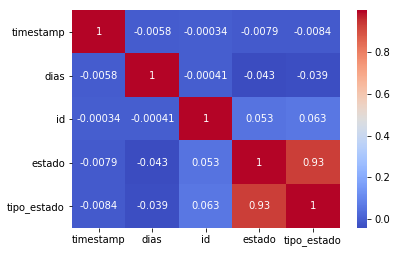

In [70]:
#Correlación
sns.heatmap(data=dataLiR_section.astype({'estado': 'int64'}).corr(),annot=True, cmap='coolwarm');

In [71]:
#División Train y Test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [72]:
#model for Linear Regression
linear = LinearRegression()  
modelo_LiR = linear.fit(X_train, y_train) #training the algorithm

In [73]:
#Precisión del Modelo con R2 valores entre 0 y 1. Más cerca de 1 mejor se adapta el modelo
print("Accuracy: ", round(linear.score(X_test, y_test)*100,3))

Accuracy:  86.743


In [74]:
#Predictions
y_pred = modelo_LiR.predict(X_test) 

In [75]:
df_predLiR_section = pd.DataFrame({'Actual': y_test, 'Predicción': y_pred.astype(int)})
df_predLiR_section.head(5)

,Actual,Predicción
5140000,1,1
773111,2,1
8522900,1,1
7150502,1,1
993326,1,1


In [76]:
# RMSE
print('RMSE: ',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE:  0.3320872447171154


**3.- k-Nearest Neighbors**

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
dataKNN_section = dataLR_section[['timestamp','dias','id','estado','tipo_estado']].copy()
dataKNN_section.head(5)

,timestamp,dias,id,estado,tipo_estado
0,1420071301,4,101,140,1
1,1420071301,4,103,35,1
2,1420071301,4,105,173,1
3,1420071301,4,107,120,1
4,1420071301,4,108,143,1


In [29]:
dataKNN_section.count()

timestamp      11729306
dias           11729306
id             11729306
estado         11729306
tipo_estado    11729306
dtype: int64

In [31]:
X = dataKNN_section[['timestamp','dias','id','estado']] # Features 
y = dataKNN_section['tipo_estado'] # Target variable

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0)

In [33]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [34]:
#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [35]:
df_predKNN_section = pd.DataFrame({'Actual': y_test, 'Predicción': y_pred})
df_predKNN_section.head(5)

,Actual,Predicción
5140000,1,1
773111,2,1
8522900,1,1
7150502,1,1
993326,1,1


In [36]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred)*100,3))

Accuracy: 97.543


**4.- Random Forest**

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
dataRF_section = dataLR_section[['timestamp','dias','id','estado','tipo_estado']].copy()
dataRF_section.head(5)

,timestamp,dias,id,estado,tipo_estado
0,1420071301,4,101,140,1
1,1420071301,4,103,35,1
2,1420071301,4,105,173,1
3,1420071301,4,107,120,1
4,1420071301,4,108,143,1


In [88]:
X = dataRF_section[['timestamp','dias','id','estado']] # Features
y = dataRF_section['tipo_estado'] # Target variable

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0)

In [90]:
current_init = datetime.datetime.now()
print ('Start: ',current_init.strftime("%H:%M:%S"))

Start:  13:45:18


In [91]:
# Instantiate model 
rf = RandomForestClassifier(n_estimators=100,max_depth=3,bootstrap=True,\
                            verbose=2,max_features = 'sqrt')

# Train the model on training data
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.2min finished


RandomForestClassifier(max_depth=3, max_features='sqrt', verbose=2)

In [92]:
current_end = datetime.datetime.now()
print ('Finish: ',current_end.strftime("%H:%M:%S"))

Finish:  13:57:45


In [93]:
#predictions
y_pred=rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.9s finished


In [94]:
df_predRF_section = pd.DataFrame({'Actual': y_test, 'Predicción': y_pred})
df_predRF_section.head(5)

,Actual,Predicción
5140000,1,1
773111,2,2
8522900,1,1
7150502,1,1
993326,1,1


In [97]:
acc_random = metrics.accuracy_score(y_test, y_pred)*100
print('Accuracy: ',round(acc_random,2))

Accuracy:  94.76


**5.- Naive Bayes** 

In [98]:
#Import Naive Bayes 
from sklearn.naive_bayes import GaussianNB

In [99]:
dataNB_section = dataLR_section[['timestamp','dias','id','estado','tipo_estado']].copy()
dataNB_section.head(5)

,timestamp,dias,id,estado,tipo_estado
0,1420071301,4,101,140,1
1,1420071301,4,103,35,1
2,1420071301,4,105,173,1
3,1420071301,4,107,120,1
4,1420071301,4,108,143,1


In [100]:
X = dataNB_section[['timestamp','dias','id','estado']] # Features
y = dataNB_section['tipo_estado'] # Target variable

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0)

In [102]:
#Classifier
modelo_NB = GaussianNB()

#Training the model 
modelo_NB.fit(X_train, y_train)

GaussianNB()

In [103]:
#Predictions
y_pred = modelo_NB.predict(X_test)

In [104]:
df_predNB_section = pd.DataFrame({'Actual': y_test, 'Predicción': y_pred})
df_predNB_section.head(5)

,Actual,Predicción
5140000,1,1
773111,2,1
8522900,1,1
7150502,1,1
993326,1,1


In [106]:
acc_naive = round(metrics.accuracy_score(y_test, y_pred)*100,3)
print("Accuracy:",acc_naive)

Accuracy: 91.893


**6.- SVM**

In [26]:
#Import svm model
from sklearn import svm

In [30]:
dataSVM_section = dataLR_section[['timestamp','dias','id','estado','tipo_estado']].copy()
dataSVM_section.head(5)

,timestamp,dias,id,estado,tipo_estado
0,1420070400,4,101,1596.896552,3
1,1420070400,4,103,308.816092,1
2,1420070400,4,105,1440.793103,2
3,1420070400,4,107,684.057471,2
4,1420070400,4,108,711.977011,2


In [31]:
dataSVM_section.count()

timestamp      142182
dias           142182
id             142182
estado         142182
tipo_estado    142182
dtype: int64

In [32]:
X = dataSVM_section[['timestamp','estado']] # Features 
y = dataSVM_section['tipo_estado'] # Target variable

In [33]:
#División Train y Test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [36]:
current_init = datetime.datetime.now()
print ('Start: ',current_init.strftime("%H:%M:%S"))

Start:  15:52:17


In [ ]:
#Create a svm Classifier
modelo_svm = svm.SVC(kernel='linear',C=1,gamma='auto') # Linear Kernel

#Train the model using the training sets
modelo_svm.fit(X_train, y_train)


current_end = datetime.datetime.now()
print ('Finish: ',current_end.strftime("%H:%M:%S"))

In [ ]:
#Predict the response for test dataset
y_pred = modelo_svm.predict(X_test)
y_pred

In [ ]:
# Model Accuracy: how often is the classifier correct?
score_svm = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score_svm,3))

**Predicciones desde dataset preparado**

In [37]:
#cargamos el dataset pred_data
data_predictions = pd.read_csv('../TFM/Machine_Learning_Data/predictions/pred_data.csv',sep=';',engine='python')
data_predictions.head(5)

,timestamp_pred,dias_pred,id,estado
0,1609460101,5,10102,30
1,1609460101,5,10104,36
2,1609460101,5,10124,149
3,1609460101,5,10127,220
4,1609460101,5,10122,353


In [38]:
data_predictions.count()

timestamp_pred    255750
dias_pred         255750
id                255750
estado            255750
dtype: int64

In [39]:
#realizamos las predicciones sobre el modelo de knn y nuestro dataset preparado
new_pred = knn.predict(data_predictions)
new_pred

array([1, 1, 1, ..., 1, 1, 1])

In [40]:
#unimos las predicciones con el dataset
data_predictions['predicciones'] = pd.Series(new_pred)
data_predictions.head(5)

,timestamp_pred,dias_pred,id,estado,predicciones
0,1609460101,5,10102,30,1
1,1609460101,5,10104,36,1
2,1609460101,5,10124,149,1
3,1609460101,5,10127,220,1
4,1609460101,5,10122,353,1


In [41]:
data_predictions.count()

timestamp_pred    255750
dias_pred         255750
id                255750
estado            255750
predicciones      255750
dtype: int64

In [42]:
data_predictions.dtypes

timestamp_pred    int64
dias_pred         int64
id                int64
estado            int64
predicciones      int64
dtype: object

In [43]:
#Reconversión timestamp a fecha y tiempo
data_predictions['date_time'] =pd.to_datetime(data_predictions['timestamp_pred'],unit='s')
data_predictions['new_date'] = [d.date() for d in data_predictions['date_time']]
data_predictions['new_time'] = [d.time() for d in data_predictions['date_time']]
dp = data_predictions[['new_date','new_time','dias_pred','id','estado','predicciones']]
dp['new_time'] =  [re.sub(r'[\d:]$','0', str(x)) for x in dp['new_time']]
dp.head(5)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,new_date,new_time,dias_pred,id,estado,predicciones
0,2021-01-01,00:15:00,5,10102,30,1
1,2021-01-01,00:15:00,5,10104,36,1
2,2021-01-01,00:15:00,5,10124,149,1
3,2021-01-01,00:15:00,5,10127,220,1
4,2021-01-01,00:15:00,5,10122,353,1


In [44]:
#Obtenmos el estado medio por cada uno de los días
data_pred_1_ML = dp.groupby(['new_date'],as_index = False)['predicciones'].mean()

data_pred_1_ML.sort_values(by=['new_date'],inplace=True)
data_pred_1_ML.set_index('new_date',inplace=True)
data_pred_1_ML.reset_index()

,new_date,predicciones
0,2021-01-01,1.313975
1,2021-01-02,1.340245
2,2021-01-03,1.346071
3,2021-01-04,1.425719
4,2021-01-05,1.328227
5,2021-01-06,1.412102
6,2021-01-07,1.424352


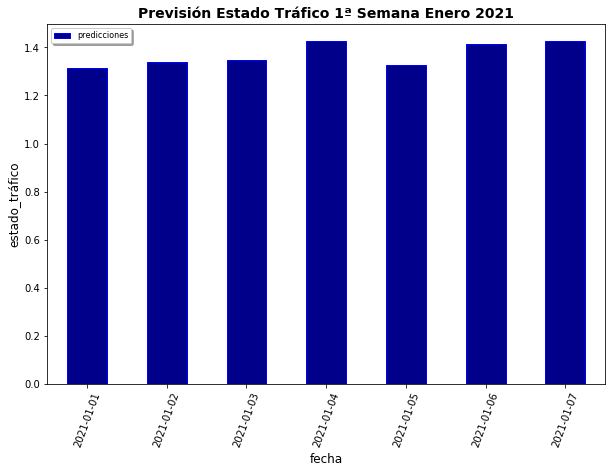

In [45]:
#Gráfica para mostrar la previsión del estado tráfico por días de 1 a 7 de Enero de 2021
data_pred_1_ML.plot(kind='bar',color='darkblue',edgecolor='blue',figsize=(10,5))
plt.title('Previsión Estado Tráfico 1ª Semana Enero 2021',fontweight='bold',fontsize=14)
plt.legend(['predicciones'],loc="upper left",fontsize=8,shadow=True)
plt.xlabel('fecha',fontsize=12)
plt.ylabel('estado_tráfico',fontsize=12)
plt.xticks(rotation=70)
plt.subplots_adjust(bottom=1, top=2)
plt.show()

In [46]:
#Filtrado de datos por Franja Horaria
data_pred_2_ML = dp.groupby(['new_time'],as_index = False)['predicciones'].mean()

data_pred_2_ML.set_index('new_time',inplace=True)
data_pred_2_ML.reset_index()

,new_time,predicciones
0,00:00:00,1.275348
1,00:15:00,1.237994
2,00:30:00,1.257984
3,00:45:00,1.253025
4,01:00:00,1.228543
...,...,...
91,22:45:00,1.369035
92,23:00:00,1.338011
93,23:15:00,1.277876
94,23:30:00,1.250709


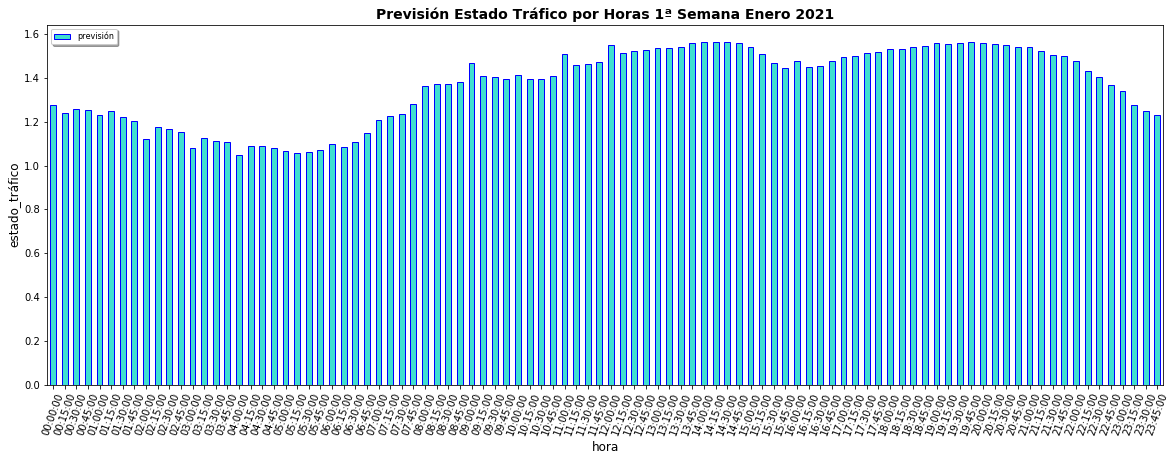

In [47]:
#Gráfica para mostrar el estado tráfico por horas de 1 a 7 de Enero de 2021
data_pred_2_ML.plot(kind='bar',color='#40E0D0',edgecolor='blue',figsize=(20,5))
plt.title('Previsión Estado Tráfico por Horas 1ª Semana Enero 2021',fontweight='bold',fontsize=14)
plt.legend(['previsión'],loc="upper left",fontsize=8,shadow=True)
plt.xlabel('hora',fontsize=12)
plt.ylabel('estado_tráfico',fontsize=12)
plt.xticks(rotation=70)
plt.subplots_adjust(bottom=1, top=2)
plt.show()

In [74]:
#Filtro por los 10 Tramos con mayor volumen de tráfico desde el 1 al 7 de Enero de 2021
data_pred_3_ML = dp.groupby(['id'],as_index = False)['predicciones'].mean()

data_pred_3_ML.set_index('id',inplace=True)
data_pred_3_ML = data_pred_3_ML.nlargest(10, ['predicciones'])
data_pred_3_ML

,predicciones
id,
10118,2.000000
1072,1.937402
10278,1.929577
10121,1.921753
10373,1.921507
10120,1.918623
10116,1.918367
10170,1.912088
10193,1.907668


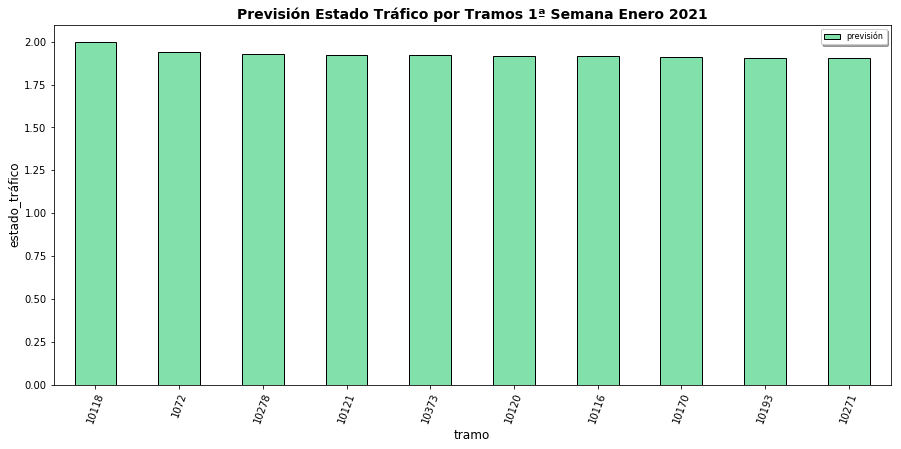

In [75]:
#Gráfica para mostrar el estado tráfico por horas de 1 a 7 de Enero de 2021
data_pred_3_ML.plot(kind='bar',color='#82e0aa',edgecolor='black',figsize=(15,5))
plt.title('Previsión Estado Tráfico por Tramos 1ª Semana Enero 2021',fontweight='bold',fontsize=14)
plt.legend(['previsión'],loc="upper right",fontsize=8,shadow=True)
plt.xlabel('tramo',fontsize=12)
plt.ylabel('estado_tráfico',fontsize=12)
plt.xticks(rotation=70)
plt.subplots_adjust(bottom=1, top=2)
plt.show()

In [76]:
data_pred_3_ML.reset_index(inplace=True)
data_pred_3_ML

,id,predicciones
0,10118,2.000000
1,1072,1.937402
2,10278,1.929577
3,10121,1.921753
4,10373,1.921507
5,10120,1.918623
6,10116,1.918367
7,10170,1.912088
8,10193,1.907668
9,10271,1.906103


In [94]:
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10118),'GERMANÍAS',data_pred_3_ML['id'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==1072),'AVDA. CID',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10278),'PUENTE DE ARAGÓN',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10121),'GRAN VIA MARQUES DEL TURIA',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10373),'ACCESO SUR (N-332)',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10120),'GRAN VIA MARQUES DEL TURIA',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10116),'GIORGETA',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10170),'NUEVE DE OCTUBRE',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10193),'PIO XII',data_pred_3_ML['des_tramo'])
data_pred_3_ML['des_tramo'] = np.where((data_pred_3_ML['id']==10271),'PUENTE DE LAS VIEJAS GLORIAS',data_pred_3_ML['des_tramo'])

In [95]:
data_pred_3_ML[['id','des_tramo','predicciones']]

,id,des_tramo,predicciones
0,10118,GERMANÍAS,2.000000
1,1072,AVDA. CID,1.937402
2,10278,PUENTE DE ARAGÓN,1.929577
3,10121,GRAN VIA MARQUES DEL TURIA,1.921753
4,10373,ACCESO SUR (N-332),1.921507
5,10120,GRAN VIA MARQUES DEL TURIA,1.918623
6,10116,GIORGETA,1.918367
7,10170,NUEVE DE OCTUBRE,1.912088
8,10193,PIO XII,1.907668
9,10271,PUENTE DE LAS VIEJAS GLORIAS,1.906103


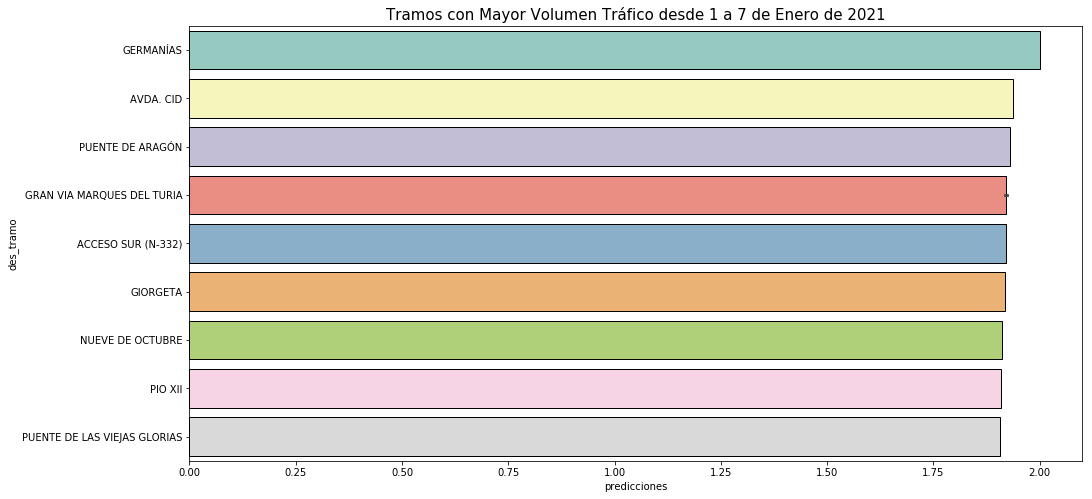

In [105]:
plt.subplots(figsize = (16,8))
ax = plt.axes()
sns.barplot(x='predicciones', y='des_tramo', data=data_pred_3_ML,\
            palette = sns.color_palette("Set3"), edgecolor = 'black')
ax.set_title('Tramos con Mayor Volumen Tráfico desde 1 a 7 de Enero de 2021',fontsize = 15)
plt.show()